# Kim Hai's Mini-Project 2: Investigating characteristics of diamonds that impact the price

## Introduction:

Diamonds are a girl's best friend and thus is one of the most important decisions a man has to make in his life. However, the average man is clueless about diamonds in general. Therefore, we can learn from previous transactions of diamond sales as recorded in diamonds.csv to see if we are able to task our trusty Machine Learning Algorithms to help point us in the right direction in purchasing the "right" diamond.

## Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet,Lasso,Ridge
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

from pandas.api.types import CategoricalDtype

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from itertools import product

## Set up data

In [2]:
diamonds_path= r"C:\Users\koh_k\Downloads\Institute of Data\Labs\Module 5\Lab 5\diamonds.csv"
diamonds_df= pd.read_csv(diamonds_path)

## Data Dictionary:
|column name|Description|
|-----------|-----------|
|carat| weight of the diamond (0.2--5.01)|
|cut| quality of the cut (Fair, Good, Very Good, Premium, Ideal)|
|color |diamond colour, from J (worst) to D (best)|
|clarity| a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))|
|x| length in mm (0--10.74)|
|y| width in mm (0--58.9)|
|z| depth in mm (0--31.8)|
|depth| total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)|
|table| width of top of diamond relative to widest point (43--95)|
|price| price in US dollars (\$326--\$18,823)|

Source: https://www.kaggle.com/datasets/shivam2503/diamonds

Reference Provided by Sumaya:

https://rpubs.com/Davo2812/1102821

https://www.kaggle.com/code/hrokrin/kaggle-s-largest-dataset-of-diamonds-eda

## Background info: 
|Column|Link|Comment|
|------|----|-------|
|Cut| https://4cs.gia.edu/en-us/blog/gia-diamond-cut-grade-six-things-to-know/|Is categorical; but Premium>Ideal>Very Good> Good> Fair>|
|Color|https://4cs.gia.edu/en-us/blog/diamond-color-seven-things-you-need-to-know/|Ranges from D -Z, but data only from D - J|


In [3]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


In [4]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
 9   price    53940 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [5]:
# since cut, color and clarity are strings and are features that are important in diamond selection, we can use one hot encoding for each option
# tag these columns as categorical first 
diamonds_df['cut']=diamonds_df['cut'].astype('category')
diamonds_df['color']=diamonds_df['color'].astype('category')
diamonds_df['clarity']=diamonds_df['clarity'].astype('category')
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   x        53940 non-null  float64 
 7   y        53940 non-null  float64 
 8   z        53940 non-null  float64 
 9   price    53940 non-null  int64   
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


## Categorical Data Summary Statistics & Analysis

In [6]:
diamonds_df['cut'].value_counts()

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

In [7]:
diamonds_df['color'].value_counts()

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

In [8]:
diamonds_df['clarity'].value_counts()

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

In [9]:
X=diamonds_df.iloc[:,:9]
#diamond_price=pd.DataFrame(diamonds_df.iloc[:,9],columns=['price'])
diamond_price = diamonds_df['price'] 
print(diamond_price)

0         326
1         326
2         327
3         334
4         335
         ... 
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53940, dtype: int64


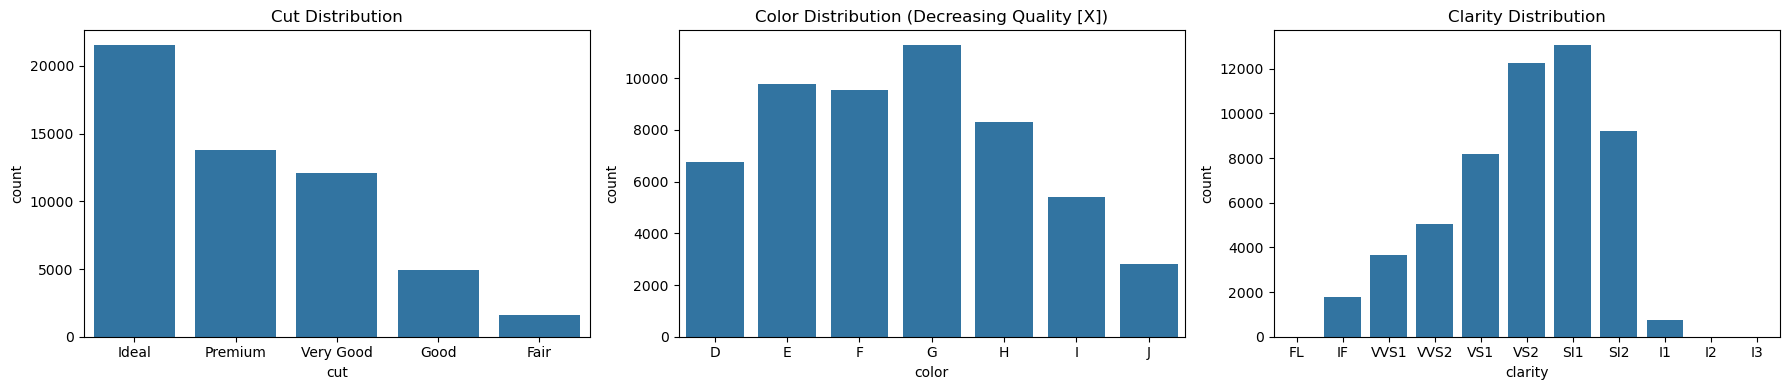

In [10]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Sorted orders
cut_order = ["Ideal","Premium","Very Good","Good","Fair"]
color_order = sorted(diamonds_df['color'].unique())
clarity_order = ["FL", "IF", "VVS1", "VVS2", "VS1", "VS2",
                 "SI1", "SI2", "I1", "I2", "I3"]
# Count plots
sns.countplot(x='cut', data=diamonds_df, order=cut_order,ax=axes[0])
sns.countplot(x='color', data=diamonds_df, order=color_order, ax=axes[1])
sns.countplot(x='clarity', data=diamonds_df,order=clarity_order, ax=axes[2])

# Titles
axes[0].set_title('Cut Distribution')
axes[1].set_title('Color Distribution (Decreasing Quality [X])')
axes[2].set_title('Clarity Distribution')

plt.tight_layout()
plt.savefig('KimHai_mini_project_2_cut_color_clarity_distribution.png')
plt.show()

### Comments on categorical data distribution
**Visualising the distribution of entries based on the various categorical columns, we can see that 'Cut' is biased towards the 'Ideal' label, decreasing along the quality axis.** 

**This makes sense as the data is about consumer diamonds at a Tiffany's store in 2017. This means that consumer trends and preferences will show up in this dataset.**

**Contrasting with this, colour and clarity are not biased towards the highest value in their respective categories. Cross-referencing with domain knowledge, this is because the distinction between the quality grades are almost imperceptible to the untrained eye at the highest qualities in these categories. Therefore, customers may make the trade-off for a comparable diamond at a cheaper price.**

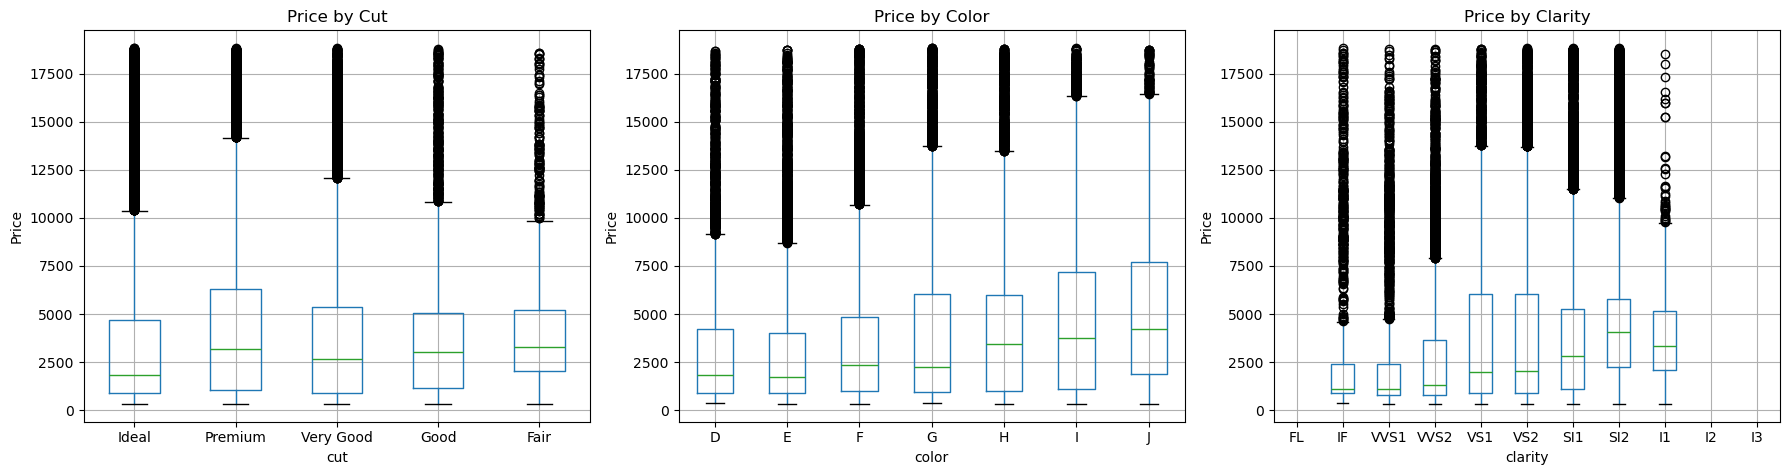

In [11]:
# Apply category ordering
diamonds_df['cut'] = diamonds_df['cut'].astype(CategoricalDtype(categories=cut_order, ordered=True))
diamonds_df['color'] = diamonds_df['color'].astype(CategoricalDtype(categories=color_order, ordered=True))
diamonds_df['clarity'] = diamonds_df['clarity'].astype(CategoricalDtype(categories=clarity_order, ordered=True))

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

diamonds_df.boxplot(column='price', by='cut', ax=axes[0])
diamonds_df.boxplot(column='price', by='color', ax=axes[1])
diamonds_df.boxplot(column='price', by='clarity', ax=axes[2])

axes[0].set_title('Price by Cut')
axes[1].set_title('Price by Color')
axes[2].set_title('Price by Clarity')

for ax in axes:
    ax.set_ylabel('Price')

plt.suptitle('')
plt.tight_layout()
plt.savefig('KimHai_mini_project_2_cut_color_clarity_boxplot.png')
plt.show()

### Comments on boxplot of categorical data: 

**Quite a lot of values lie outside of the inter-quartile range in all values in all categories.**

**In general, these should be investigated if they should be removed, but because diamond grading contains an element of subjectiveness, we want to capture the perceived value each feature brings.**

**Additonally, the average (mean) price along the quality axis across all categories are not on a negative trend line as initially expected. This suggests that perhaps these categories do not have as large an impact on the final price as initially assumed, therefore we will next investigate the numerical data.**

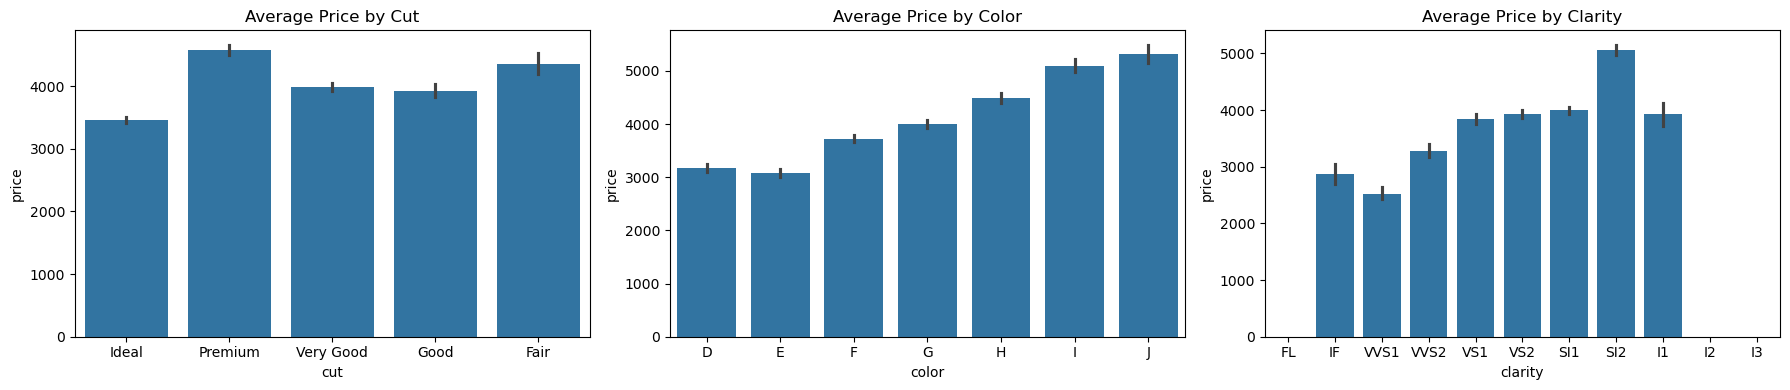

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
 
sns.barplot(x='cut', y='price', data=diamonds_df, order=cut_order, ax=axes[0])
sns.barplot(x='color', y='price', data=diamonds_df, order=color_order, ax=axes[1])
sns.barplot(x='clarity', y='price', data=diamonds_df, order=clarity_order, ax=axes[2])

axes[0].set_title('Average Price by Cut')
axes[1].set_title('Average Price by Color')
axes[2].set_title('Average Price by Clarity')

plt.tight_layout()
plt.savefig('KimHai_mini_project_2_cut_color_clarity_average_price_per_quality.png')
plt.show()

#### Further comments on average price by colour:

**Not only is there not a negative trendline, there appears to be a positive trendline. This could be due to the other features of the low colour quality diamonds in the dataset that make them command a higher price, ie, larger diamond, better cut and clarity. Therefore, we should keep in mind that color will likely have a very small impact despite the marketing hype by the diamond industry.**

In [13]:
# Why is the worst colour and cut performing better than higher grades in the same category? This defies expectations: 
diamonds_df.iloc[np.where(diamonds_df['cut']=='Ideal')]
#pd.set_option("display.max_rows", None, "display.max_columns", None)
print(diamonds_df.groupby(['cut','color','clarity'],observed=True)['price'].mean())
#pd.reset_option('display.max_rows')

# Maybe the other features have more impact?

cut    color  clarity
Ideal  D      IF         6567.178571
              VVS1       2705.777778
              VVS2       3619.014085
              VS1        2576.039886
              VS2        2111.927174
                            ...     
Fair   J      VS1        5906.187500
              VS2        4067.826087
              SI1        4553.928571
              SI2        5131.814815
              I1         5795.043478
Name: price, Length: 276, dtype: float64


In [14]:
# Check numerical columns for collinearity
numerical_features_df=diamonds_df[['carat','table','depth','x','y','z','price']]
numerical_features_df.corr()


,carat,table,depth,x,y,z,price
carat,1.000000,0.181618,0.028224,0.975094,0.951722,0.953387,0.921591
table,0.181618,1.000000,-0.295779,0.195344,0.183760,0.150929,0.127134
depth,0.028224,-0.295779,1.000000,-0.025289,-0.029341,0.094924,-0.010647
x,0.975094,0.195344,-0.025289,1.000000,0.974701,0.970772,0.884435
y,0.951722,0.183760,-0.029341,0.974701,1.000000,0.952006,0.865421
z,0.953387,0.150929,0.094924,0.970772,0.952006,1.000000,0.861249
price,0.921591,0.127134,-0.010647,0.884435,0.865421,0.861249,1.000000


<Figure size 640x480 with 0 Axes>

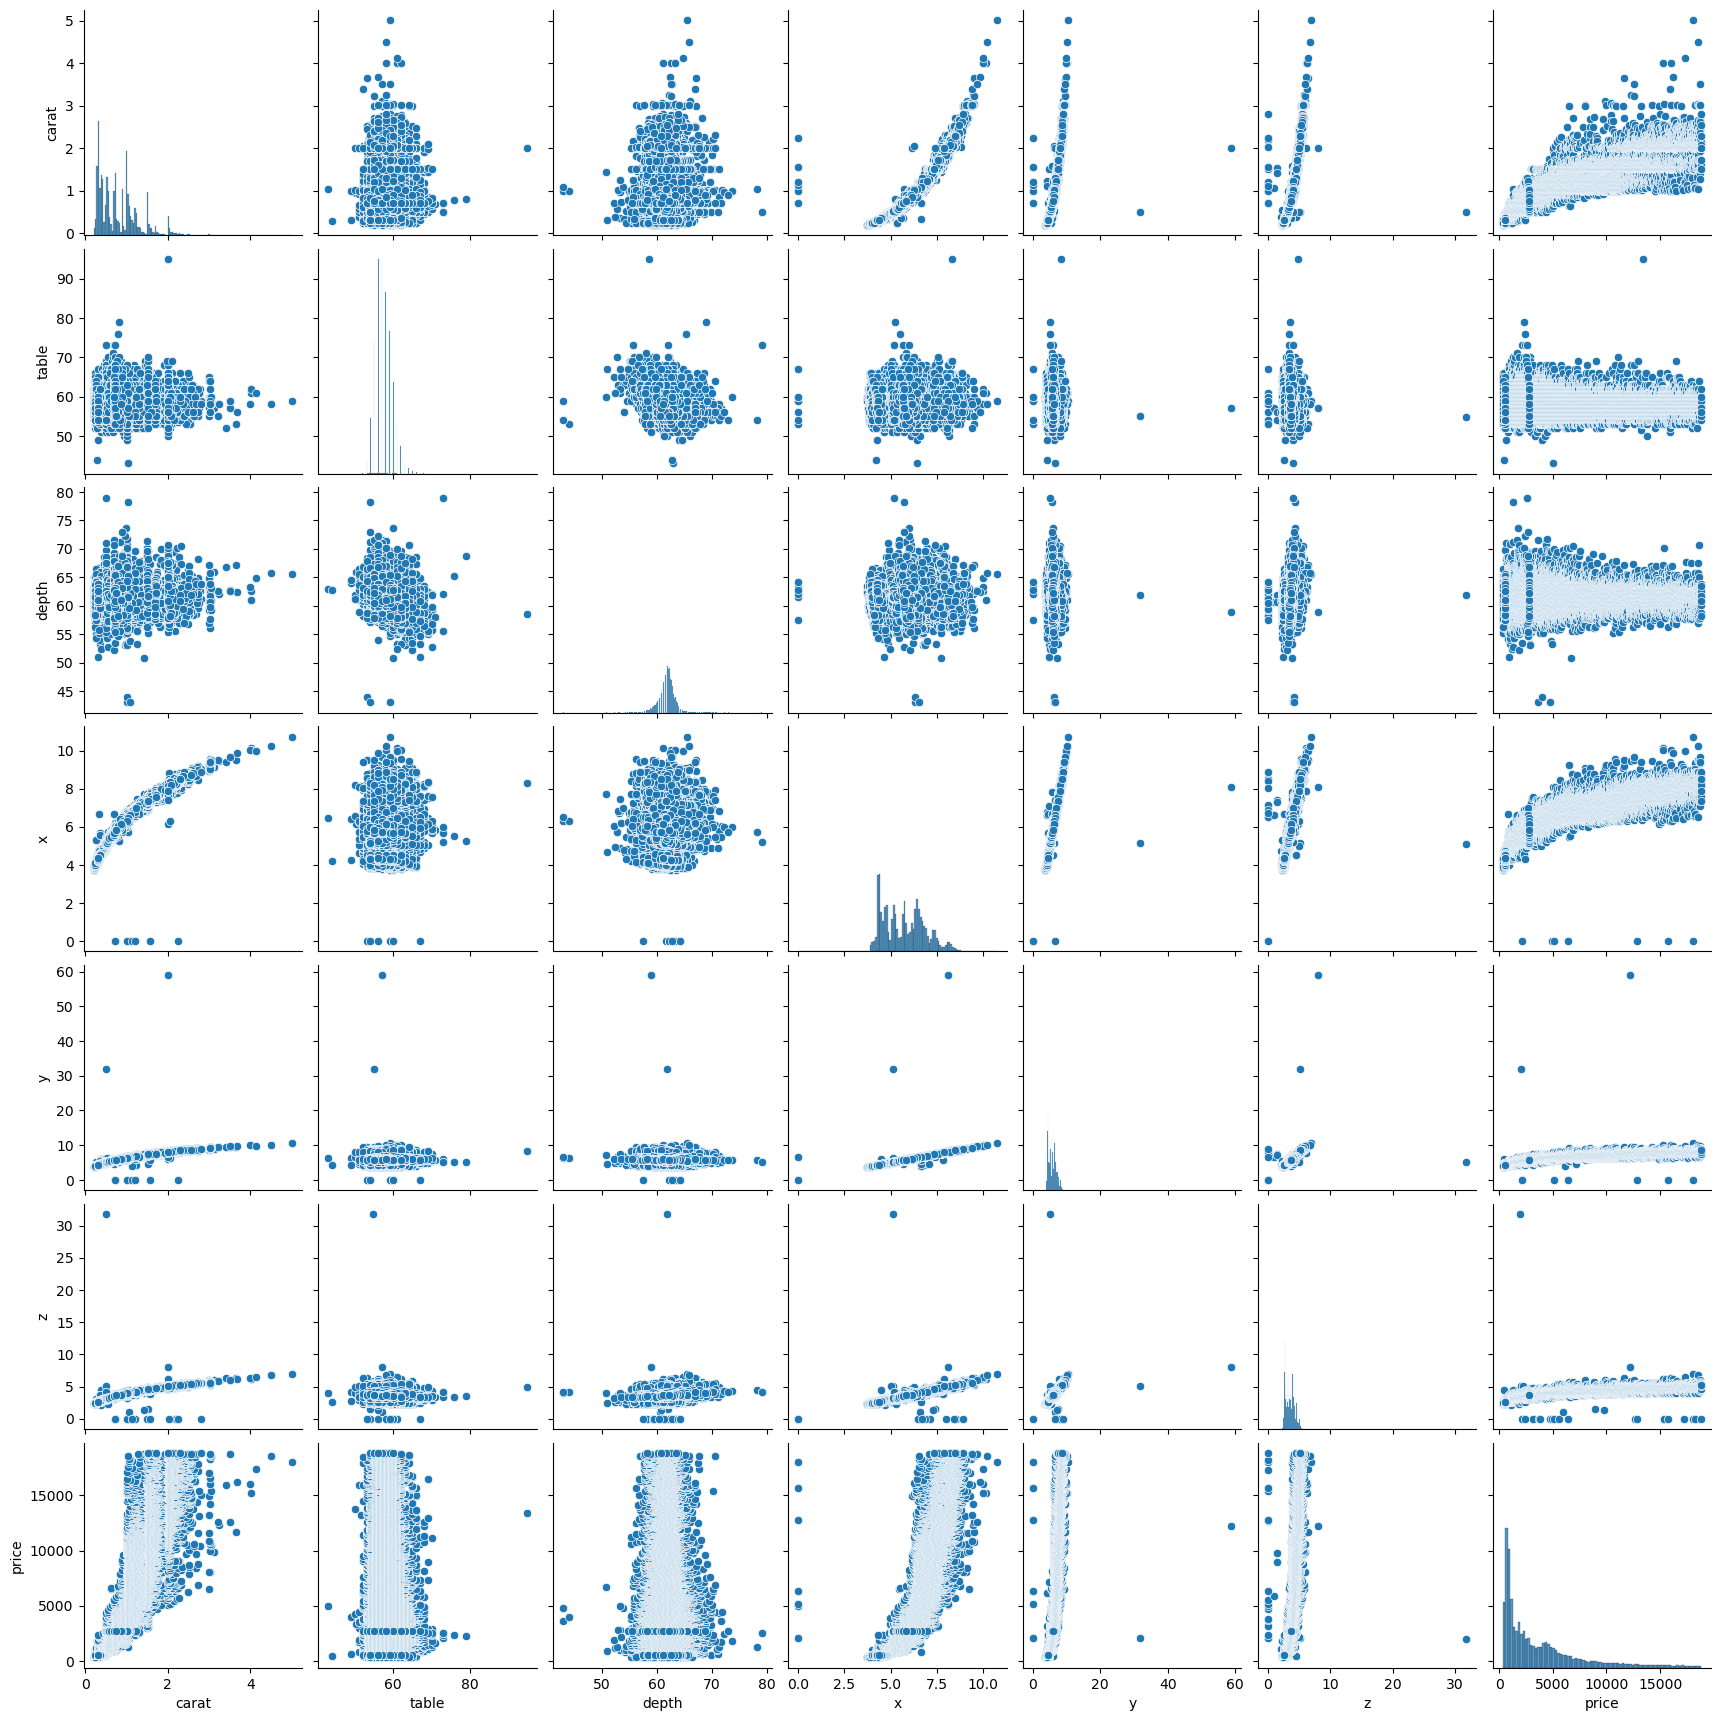

In [15]:
plt.figure()
sns.pairplot(numerical_features_df)
plt.savefig('KimHai_mini_project_2_features_pairplot.png')
plt.show()

### Comments on numerical data pairplots:

**We can see that carat has a very high corr score with price, more mass= more diamond => higher prices**

**x,y,z has high corr score, which makes sense, as x,y,z is =ve corr with volume, mass= vol * density**

**We can drop table and depth from feature as they are only weakly related with other features and price**


In [16]:
X.drop(['table','depth'],axis=1,inplace=True)
numerical_features_df.drop(['table','depth'],axis=1)

,carat,x,y,z,price
0,0.23,3.95,3.98,2.43,326
1,0.21,3.89,3.84,2.31,326
2,0.23,4.05,4.07,2.31,327
3,0.29,4.20,4.23,2.63,334
4,0.31,4.34,4.35,2.75,335
...,...,...,...,...,...
53935,0.72,5.75,5.76,3.50,2757
53936,0.72,5.69,5.75,3.61,2757
53937,0.70,5.66,5.68,3.56,2757
53938,0.86,6.15,6.12,3.74,2757


## Build Regression Models

### Linear Regression

Will need to convert categorical data with ordinal encoding to predict diamond price for given physical characteristics

In [17]:
print(X)

       carat        cut color clarity     x     y     z
0       0.23      Ideal     E     SI2  3.95  3.98  2.43
1       0.21    Premium     E     SI1  3.89  3.84  2.31
2       0.23       Good     E     VS1  4.05  4.07  2.31
3       0.29    Premium     I     VS2  4.20  4.23  2.63
4       0.31       Good     J     SI2  4.34  4.35  2.75
...      ...        ...   ...     ...   ...   ...   ...
53935   0.72      Ideal     D     SI1  5.75  5.76  3.50
53936   0.72       Good     D     SI1  5.69  5.75  3.61
53937   0.70  Very Good     D     SI1  5.66  5.68  3.56
53938   0.86    Premium     H     SI2  6.15  6.12  3.74
53939   0.75      Ideal     D     SI2  5.83  5.87  3.64

[53940 rows x 7 columns]


In [18]:
# Using all the selected features (without formal feature selection), predict the price of a diamond of similar characteristics 
#dummifiedX=pd.get_dummies(X,prefix=['cut','color','clarity']) ## get ordinal
encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])
ordinal_encoded = encoder.fit_transform(diamonds_df[['cut', 'color', 'clarity']])
ordinal_df = pd.DataFrame(ordinal_encoded, columns=['cut_encoded', 'color_encoded', 'clarity_encoded'])
# Select numerical columns
numerical_df = diamonds_df.drop(columns=['cut', 'color', 'clarity', 'price','table','depth','z']) # x,y,z have high degree of collinearity with each other

# Combine them
OrdDumX= pd.concat([ordinal_df, numerical_df.reset_index(drop=True)], axis=1)
print(OrdDumX.value_counts())


cut_encoded  color_encoded  clarity_encoded  carat  x      y    
0.0          2.0            1.0              0.31   4.35   4.38     7
                                                    4.38   4.41     7
             1.0            5.0              0.30   4.30   4.34     7
             0.0            5.0              0.33   4.46   4.43     6
             1.0            5.0              0.30   4.29   4.33     6
                                                                   ..
             5.0            5.0              1.69   7.74   7.77     1
                                             1.70   7.64   7.72     1
                                                    7.70   7.66     1
                                                    7.72   7.64     1
4.0          6.0            8.0              5.01   10.74  10.54    1
Name: count, Length: 50975, dtype: int64


### Clean the final dataframe

In [19]:
## De-duplicate 
# Step 1: Get mask of duplicated rows
duplicates_mask = OrdDumX.duplicated()

In [20]:
# Step 2: Remove duplicated rows from both features and target
OrdDumX = OrdDumX[~duplicates_mask].reset_index(drop=True)
diamond_price = diamond_price[~duplicates_mask].reset_index(drop=True)

In [21]:
## Remove 0 values in dimension measurements
x0_index=np.where(OrdDumX['x']==0)[0]
y0_index=np.where(OrdDumX['y']==0)[0]
#z0_index=np.where(OrdDumX['z']==0)[0]

#print(f'x0index: {x0_index}\ny0index: {y0_index}\nz0index: {z0_index}')
# Combine, sort, and get unique indices
#zero_indices = np.unique(np.concatenate([x0_index, y0_index, z0_index]))
zero_indices = np.unique(np.concatenate([x0_index, y0_index]))
OrdDumX = OrdDumX.drop(index=zero_indices).reset_index(drop=True)
diamond_price = diamond_price.drop(index=zero_indices).reset_index(drop=True)

In [22]:
OrdDumX.corr()

,cut_encoded,color_encoded,clarity_encoded,carat,x,y
cut_encoded,1.000000,0.013118,0.176223,0.115281,0.103980,0.100391
color_encoded,0.013118,1.000000,-0.024648,0.286667,0.265643,0.258547
clarity_encoded,0.176223,-0.024648,1.000000,0.345086,0.364012,0.349835
carat,0.115281,0.286667,0.345086,1.000000,0.977620,0.952408
x,0.103980,0.265643,0.364012,0.977620,1.000000,0.973420
y,0.100391,0.258547,0.349835,0.952408,0.973420,1.000000


In [23]:
pd.concat([OrdDumX,diamond_price],axis=1).corr()

,cut_encoded,color_encoded,clarity_encoded,carat,x,y,price
cut_encoded,1.000000,0.013118,0.176223,0.115281,0.103980,0.100391,0.036081
color_encoded,0.013118,1.000000,-0.024648,0.286667,0.265643,0.258547,0.165026
clarity_encoded,0.176223,-0.024648,1.000000,0.345086,0.364012,0.349835,0.135518
carat,0.115281,0.286667,0.345086,1.000000,0.977620,0.952408,0.920095
x,0.103980,0.265643,0.364012,0.977620,1.000000,0.973420,0.886042
y,0.100391,0.258547,0.349835,0.952408,0.973420,1.000000,0.865500
price,0.036081,0.165026,0.135518,0.920095,0.886042,0.865500,1.000000


<Figure size 640x480 with 0 Axes>

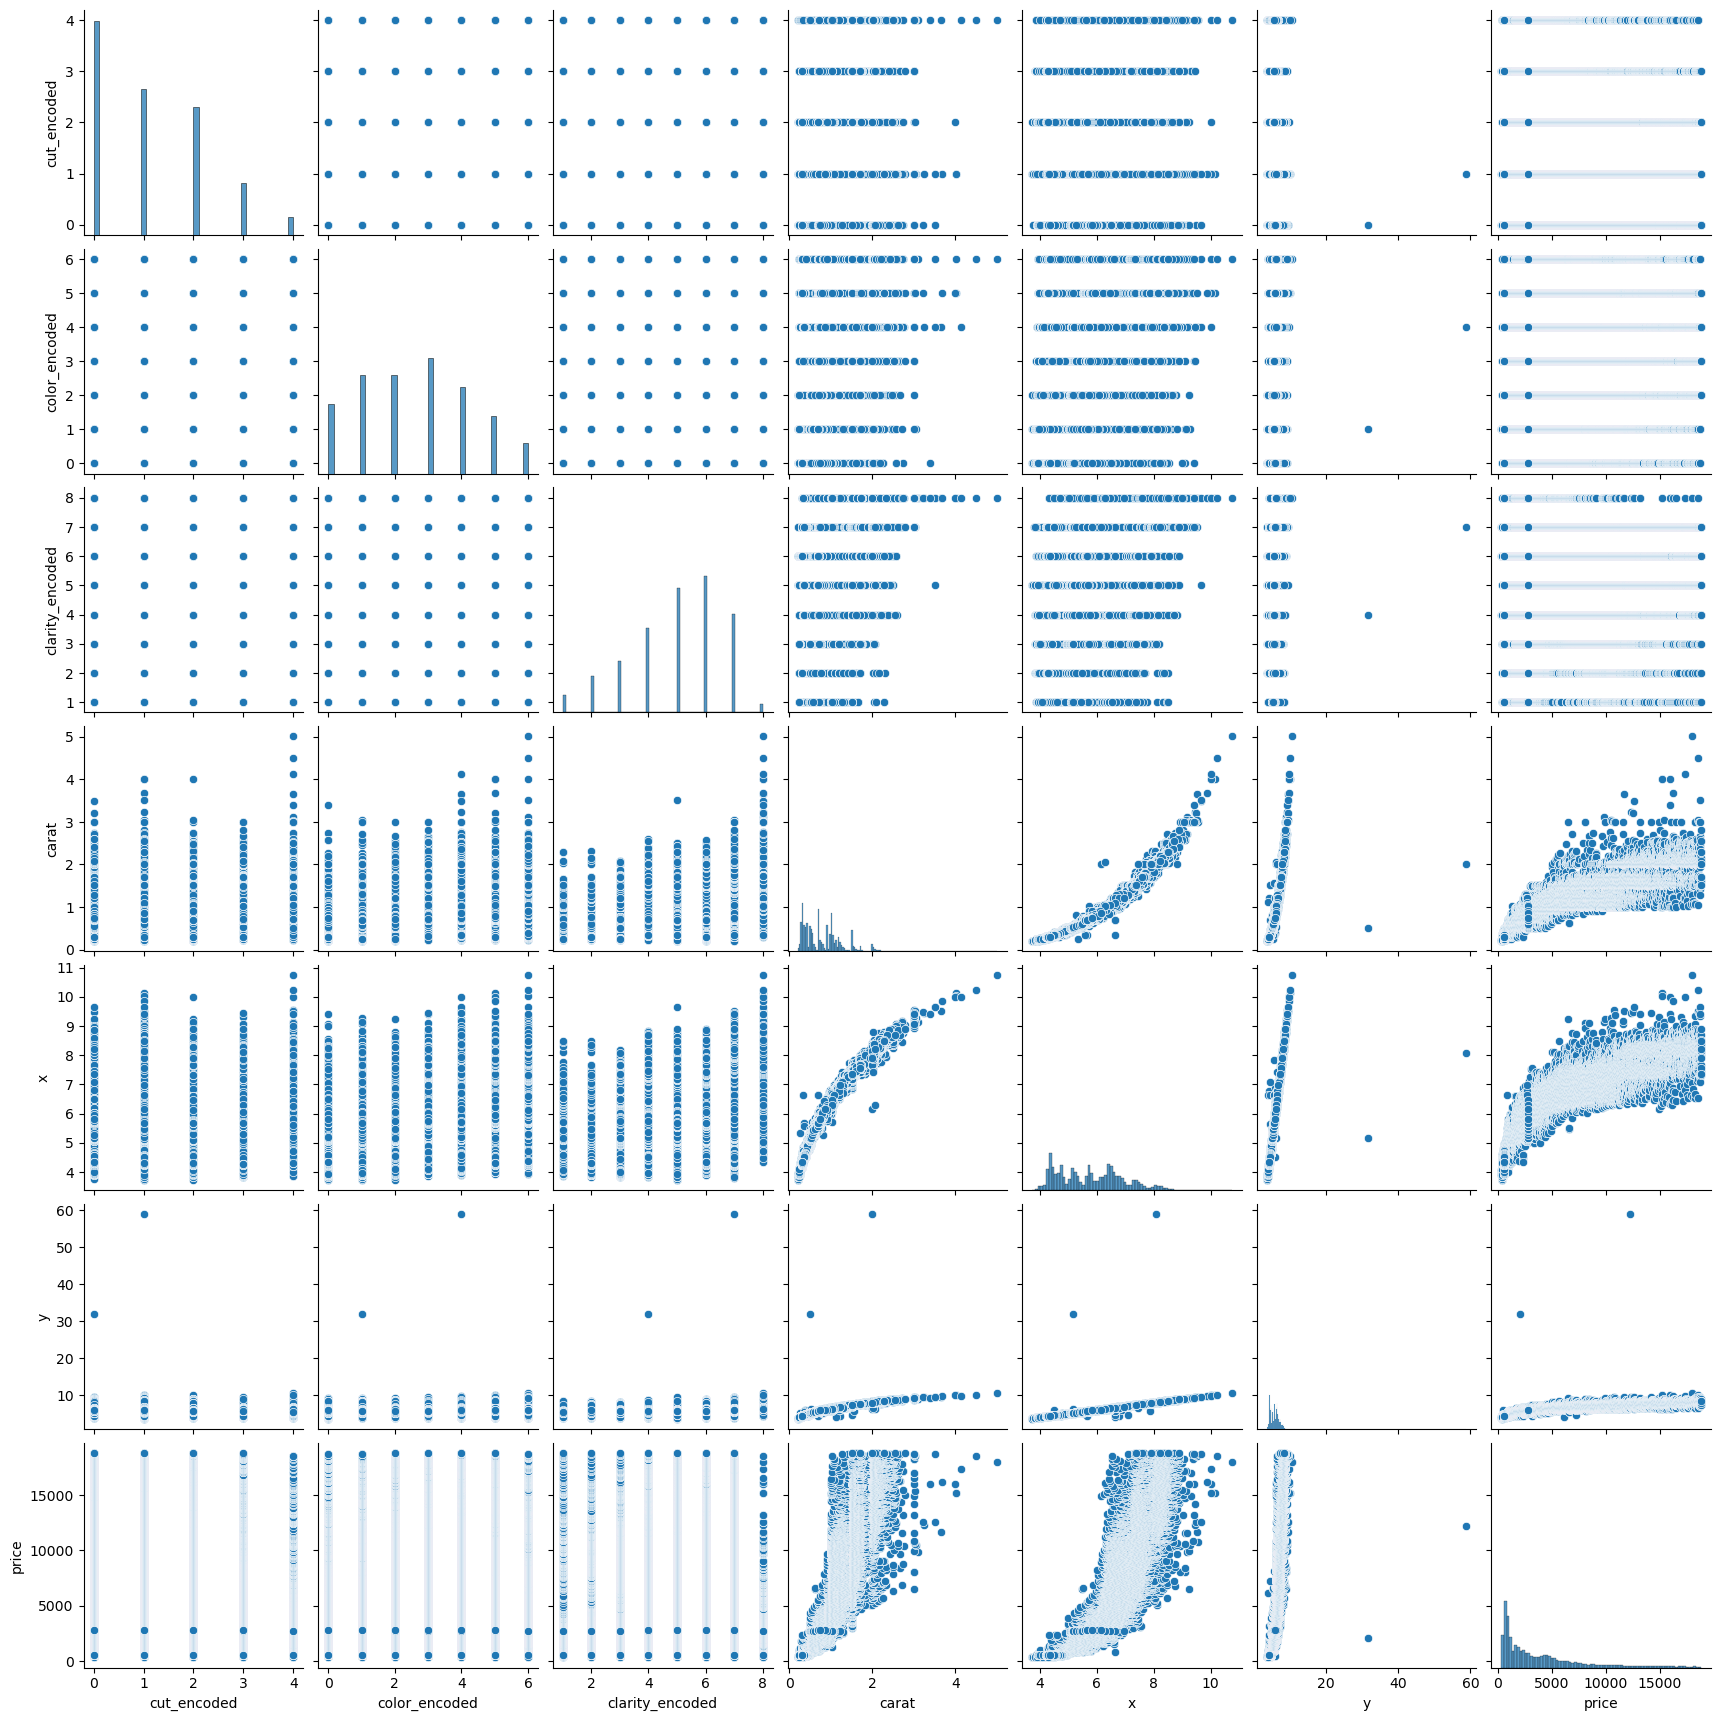

In [24]:
plt.figure()
sns.pairplot(pd.concat([OrdDumX,diamond_price],axis=1))
plt.savefig('KimHai_mini_project_2_final_features_pairplot.png')
plt.show()

### Comments on Ordinal Encoded - Normalised Feature Dataframe (OrdDumX):

**x,y and carat show a very strong relationship with price, keeping in line with our initial assessment that the larger (in size and mass) the diamond, the higher a prce it can command.**

**For each value in the categorical data, there are a range of values, this can be interpreted that perhaps as initially assessed, the 4Cs as pushed by the diamond industry does not have great bearing on the price paid for by customers.**

In [25]:
# Split the data 
Xtrain,Xtest,ytrain,ytest= train_test_split(OrdDumX, diamond_price, test_size=0.2,random_state=0)

#normalise the split data using StandardScalar() 
scaler=StandardScaler()
Xtrain_norm=pd.DataFrame(scaler.fit_transform(Xtrain),columns=Xtrain.columns)
Xtest_norm=pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns)

In [26]:
# Fit training data onto model 
lrModel=LinearRegression()
lrModel.fit(Xtrain_norm,ytrain)

# Assess Model on training data 
print(lrModel.score(Xtrain_norm,ytrain)) # 0.9064 before data clean
# Predict using test data 
print(lrModel.score(Xtest_norm,ytest))   # 0.8910 before data clean
# R^2 is around the 90% mark, this is reasonable as data was not cleaned fully; a lot of outliers as seen in the boxplots for the respective columns

0.9040457615421946
0.9111742213527672


### Regression Prediction

In [27]:
OrdDumX.columns

Index(['cut_encoded', 'color_encoded', 'clarity_encoded', 'carat', 'x', 'y'], dtype='object')

In [28]:
OrdDumX.describe()

,cut_encoded,color_encoded,clarity_encoded,carat,x,y
count,50968.000000,50968.000000,50968.000000,50968.000000,50968.000000,50968.000000
mean,1.126197,2.619506,4.978849,0.813731,5.774354,5.777403
std,1.119451,1.710628,1.641377,0.475307,1.116250,1.138793
min,0.000000,0.000000,1.000000,0.200000,3.730000,3.680000
25%,0.000000,1.000000,4.000000,0.410000,4.750000,4.760000
50%,1.000000,3.000000,5.000000,0.710000,5.730000,5.750000
75%,2.000000,4.000000,6.000000,1.060000,6.570000,6.560000
max,4.000000,6.000000,8.000000,5.010000,10.740000,58.900000


In [29]:
'''
The 'best' diamond could be argued to be one with the best value of each feature, 
so make a prediction of the expected price we can pay for the 'best' diamond
'''
best_cut=OrdDumX['cut_encoded'].min()
best_color=OrdDumX['color_encoded'].min()
best_clarity=OrdDumX['clarity_encoded'].min()

best_carat=OrdDumX['carat'].max()
best_xdim=OrdDumX['x'].max()
best_ydim=OrdDumX['y'].max()
'''
best_zdim=OrdDumX['z'].max()

best_diamond_max_values=pd.DataFrame([[best_cut,best_color,best_clarity,
                                     best_carat,best_xdim,best_ydim,best_zdim]],
                                    columns=OrdDumX.columns) 
'''
best_diamond_max_values=pd.DataFrame([[best_cut,best_color,best_clarity,
                                     best_carat,best_xdim,best_ydim]],
                                    columns=OrdDumX.columns) 
best_diamond_max_value_price=lrModel.predict(best_diamond_max_values)
print(f"Raw Data Maximum price:\t\t\t${diamonds_df['price'].max()}")
print(f"Training Data Maximum price:\t\t${ytrain.max()}")
print(f"Predicted Price:\t\t\t${best_diamond_max_value_price.item()}") 

print(best_diamond_max_values)
#print(pd.DataFrame(diamonds_df.iloc[np.where(diamonds_df['price']==diamonds_df['price'].max())],columns=OrdDumX.columns))
print(diamonds_df.iloc[np.where(diamonds_df['price']==diamonds_df['price'].max())]) # remap strings into float values?

Raw Data Maximum price:			$18823
Training Data Maximum price:		$18823
Predicted Price:			$21804.31805789271
   cut_encoded  color_encoded  clarity_encoded  carat      x     y
0          0.0            0.0              1.0   5.01  10.74  58.9
       carat      cut color clarity  depth  table    x     y     z  price
27749   2.29  Premium     I     VS2   60.8   60.0  8.5  8.47  5.16  18823


**Above model result was returned without cross-validation, could have some bias inherent in the data during the train_test_split**

### Linear Model Performance Evaluation:

In [30]:
# Linear Regression has no hyper-parameters to tune 
# First, evaluate the current LinearRegression model with cross_val_score() 
scores = cross_val_score(lrModel, Xtrain, ytrain, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())
# Average R² value of 0.903 is very close to non-cross-validated score of 0.908


Cross-validated R² scores: [0.89802494 0.90514772 0.91269396 0.89740726 0.90544998]
Average R²: 0.9037447726957627


## Using Ridge Linear Model with GridSearch()

In [31]:

params = {'alpha': np.logspace(0, 3, 10)} # exponential range from 1 to 1000
ridgeGrid = GridSearchCV(Ridge(), params, cv=5, scoring='r2')
ridgeGrid.fit(Xtrain_norm, ytrain)

print("Best alpha:", ridgeGrid.best_params_['alpha'])
print("Best R²:", ridgeGrid.best_score_)
# Evaluate on test set
ridgeBest = ridgeGrid.best_estimator_
print("Test R²:", ridgeBest.score(Xtest_norm, ytest))

Best alpha: 21.544346900318832
Best R²: 0.9037847149162029
Test R²: 0.9110976696034505


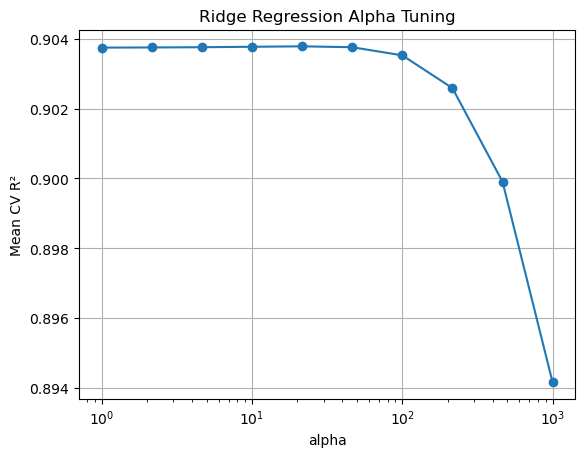

In [32]:
# Visualise alpha vs R²

results = ridgeGrid.cv_results_
alphas = results['param_alpha'].data
mean_r2 = results['mean_test_score']

plt.semilogx(alphas, mean_r2, marker='o')
plt.xlabel('alpha')
plt.ylabel('Mean CV R²')
plt.title('Ridge Regression Alpha Tuning')
plt.grid(True)
plt.savefig('KimHai_mini_project_2_ridge_reg_alpha_tuning.png')
plt.show()

# Alpha value is around maximum of diagram; well-centered

### Comments on Ridge Regression Alpha tuning: 

On the logistic range from 1 to 1000, we can see the R² value increase slowly until the best alpha was found and then it dropped precipitously until the end of the range.

### Predicting price of 'Best' Diamond with Ridge model: 

In [33]:
ridge_price=ridgeBest.predict(best_diamond_max_values)
print(f"Raw Data Maximum price:\t\t\t${diamonds_df['price'].max()}")
print(f"Training Data Maximum price:\t\t${ytrain.max()}")
print(f"Linear Predicted Price:\t\t\t${best_diamond_max_value_price.item()}") 
print(f"Ridge Model Predicted Price:\t\t${ridge_price.item()}\n\n")
for name, value in zip(OrdDumX.columns,ridgeBest.coef_):
    print(f"Ridge penalties: {name}:\t\t{value}")

Raw Data Maximum price:			$18823
Training Data Maximum price:		$18823
Linear Predicted Price:			$21804.31805789271
Ridge Model Predicted Price:		$21877.49142890915


Ridge penalties: cut_encoded:		-186.78224267978817
Ridge penalties: color_encoded:		-561.334719877056
Ridge penalties: clarity_encoded:		-853.661976338227
Ridge penalties: carat:		4988.258432058335
Ridge penalties: x:		-890.4395581090463
Ridge penalties: y:		55.395610394490234


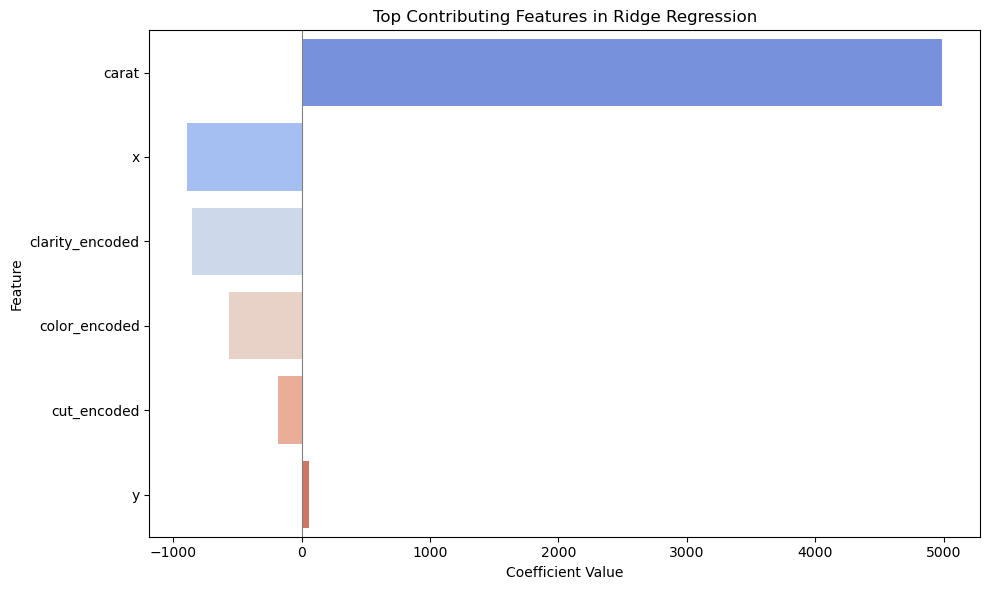

In [34]:
# Step 1: Get coefficients and feature names
ridge_coefs = pd.Series(ridgeBest.coef_, index=OrdDumX.columns)

# Step 2: Sort by absolute value
top_coefs = ridge_coefs.reindex(ridge_coefs.abs().sort_values(ascending=False).index)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_coefs.values, y=top_coefs.index, palette='coolwarm',hue=top_coefs.index)
plt.title('Top Contributing Features in Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.savefig('KimHai_mini_project_2_top_ridge_features.png')
plt.show()

### Comments on Ridge Regression Model 

#### Predictions and Penalties: 
**The penalties of the categorical data columns are all negative, indicating that the smaller the value of these features, the higher the price which is expected as the smaller values of these features are better due to the order defined earlier.**

**What is slightly unexpected is that they rank as the third through fifth most important features, after x and carat. This indicates that the 'Carat' feature is just that dominant in the prices that customers paid at Tiffany's in 2017. It may be interesting to see if this is true for past and future years and across retailers.**

**Due to the linear nature of the model and the clustering of the dataset, the set of features being predicted does not actually exists within the ~40K rows of the dataset. This may explain why it has extrapolated from the existing data to predict a price that is outside the range of 'Price' in the dataset.**

#### Top Features:
|Feature Name:|Description|
|---|---|
|carat|weight of the diamond (0.2--5.01)|
|x|length in mm (0--10.74)|
|clarity|a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))|
|color|diamond colour, from J (worst) to D (best)|
|cut|quality of the cut (Fair, Good, Very Good, Premium, Ideal)|
|y| width in mm (0--58.9)|

## Using Lasso Linear Model with GridSearch()

In [35]:
lasso_params = {'alpha': np.logspace(-4, 1, 20)}  # e.g., from 0.0001 to 10
lassoGrid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='r2')
lassoGrid.fit(Xtrain_norm, ytrain)

lassoBest = lassoGrid.best_estimator_
print("Best alpha:", lassoGrid.best_params_['alpha'])

Best alpha: 1.623776739188721


### Predicting price of 'Best' Diamond with Lasso model: 

In [36]:
lasso_price=lassoBest.predict(best_diamond_max_values)
print(f"Raw Data Maximum price:\t\t\t${diamonds_df['price'].max()}")
print(f"Training Data Maximum price:\t\t${ytrain.max()}")
print(f"Linear Predicted Price:\t\t\t${best_diamond_max_value_price.item()}") 
print(f"Lasso Model Predicted Price:\t\t${lasso_price.item()}\n\n")
lasso_coefs = pd.Series(lassoBest.coef_, index=OrdDumX.columns)
print(f"Lasso penalties:\n{lasso_coefs}")

Raw Data Maximum price:			$18823
Training Data Maximum price:		$18823
Linear Predicted Price:			$21804.31805789271
Lasso Model Predicted Price:		$19864.98442620038


Lasso penalties:
cut_encoded        -185.410732
color_encoded      -560.011115
clarity_encoded    -853.094245
carat              4983.871515
x                  -844.969865
y                    13.299842
dtype: float64


In [37]:
# Remove features with zero coefficients
nonzero_coefs = lasso_coefs[lasso_coefs != 0]

# Sort by absolute importance
top_lasso_coefs = nonzero_coefs.reindex(nonzero_coefs.abs().sort_values(ascending=False).index)

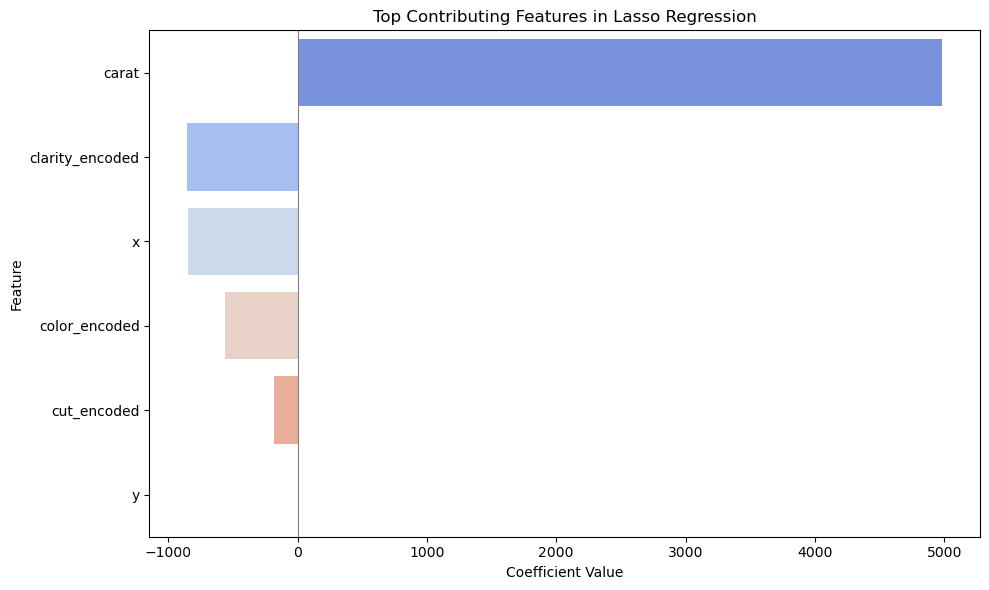

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_lasso_coefs.values, y=top_lasso_coefs.index, palette='coolwarm',hue=top_lasso_coefs.index)
plt.title('Top Contributing Features in Lasso Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.savefig('KimHai_mini_project_2_top_lasso_features.png')
plt.show()

### Comments on Lasso Regression Model:

#### Predictions and Penalties: 
**The Lasso Regression Model predicted a price that was lower than the Ridge Regression Model but still higher than the linear model and the dataset maximum.**

**The main difference between the Lasso Regression Model and Ridge Regression Model is the swapping of positions between the clarity_encoded and the 'x' features. It has also reduced the penalty on the 'y' variable. It is unclear why the 'x' and 'y' features have this inverse relationship, but it could be due to the high degree of collinearity between these 2 columns.**

#### Top Features:
|Feature Name:|Description|
|---|---|
|carat|weight of the diamond (0.2--5.01)|
|clarity|a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))|
|x|length in mm (0--10.74)|
|color|diamond colour, from J (worst) to D (best)|
|cut|quality of the cut (Fair, Good, Very Good, Premium, Ideal)|
|y| width in mm (0--58.9)|

## Conclusion

### Summary Data:

In [39]:
print(f"Raw Data Maximum price:\t\t\t${diamonds_df['price'].max()}")
print(f"Training Data Maximum price:\t\t${ytrain.max()}")
print(f"Linear Predicted Price:\t\t\t${best_diamond_max_value_price.item()}") 
print(f"Ridge Model Predicted Price:\t\t${ridge_price.item()}")
print(f"Lasso Model Predicted Price:\t\t${lasso_price.item()}\n")


Raw Data Maximum price:			$18823
Training Data Maximum price:		$18823
Linear Predicted Price:			$21804.31805789271
Ridge Model Predicted Price:		$21877.49142890915
Lasso Model Predicted Price:		$19864.98442620038



**Interpretation:**
 
All models explain ~91% of the test data variance, meaning they generalize well.

The differences are minimal → the data is well-conditioned, with few irrelevant/noisy features.

Regularization (Ridge/Lasso) doesn’t help much here — probably because:

 - Features are already informative.

 - Multicollinearity is not harming the model much.

 - No heavy outliers or extreme feature skew.

Predicted values are also greater than maximum value in the raw data.

**Why does this happen?**

Linear models — LinearRegression, Ridge, Lasso — which can extrapolate beyond the range of training data:

These models don't "know" the limits of real-world constraints.

Feeding them extreme feature combinations (e.g., maximum values for every feature) will linearly extend the trend.

This point likely doesn’t exist in the training data, so your model is making a pure extrapolation, hence the price goes beyond $18,823.



|Context                             | Concern? | Why                                                               |
|----------------------------------- | ----------------- | ----------------------------------------------------------------- |
| [O] Exploratory analysis              | Not really        | Extrapolation helps assess model behavior                         |
| [O] Hypothetical predictions          | Some concern      | Model might overestimate in unseen feature combinations           |
| [X] Real-world pricing or appraisals  | **Yes**           | The model **has no safeguard** against unrealistic extrapolations |
| [X] Regulatory or safety-critical use | **Absolutely**    | Must restrict predictions to the data's valid range           |


### Compare R² scores across the 3 models:

In [40]:
print("Train R² (Linear):", lrModel.score(Xtrain_norm, ytrain))
print("Test R² (Linear):", lrModel.score(Xtest_norm, ytest))

print("Train R² (Ridge):", ridgeBest.score(Xtrain_norm, ytrain))
print("Test R² (Ridge):", ridgeBest.score(Xtest_norm, ytest))

print("Train R² (Lasso):", lassoBest.score(Xtrain_norm, ytrain))
print("Test R² (Lasso):", lassoBest.score(Xtest_norm, ytest))

Train R² (Linear): 0.9040457615421946
Test R² (Linear): 0.9111742213527672
Train R² (Ridge): 0.9040318299438742
Test R² (Ridge): 0.9110976696034505
Train R² (Lasso): 0.9040201057770959
Test R² (Lasso): 0.9110695701722802


**What this means:**

The Ridge and Linear predictions are very similar → Ridge didn’t shrink weights much.

Lasso is meaningfully different (~$2,000 less), likely because it zeroed out some features.

**This suggests:**

Lasso is more conservative, only using a subset of features.

Linear/Ridge are using more features, possibly extrapolating more aggressively.

**Is the $2,000+ difference meaningful?**

Yes, in real-world decision-making, that’s a non-trivial difference, especially:

 - If a customer relies on this for pricing or appraisal.

 - If comparing investment value.

Even if R² is similar, the actual predicted values (especially in edge cases like the "best" diamond) can diverge significantly, especially if:

 - Some features grow unusually large and influence predictions in Linear/Ridge.

 - Lasso discards these extreme-effect features.

# Non-Assessed Exploration:

## ElasticNet Evaluation

In [41]:
eNet_param_grid = {
    'alpha': np.logspace(-4, 1, 10),       # Try values from 0.0001 to 10
    'l1_ratio': np.linspace(0.1, 0.9, 9)   # 10% Lasso to 90% Lasso
}
elastic_net = ElasticNet(max_iter=10000)  # high max_iter to ensure convergence

eNet_grid_search = GridSearchCV(estimator=elastic_net,
                           param_grid=eNet_param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1)

eNet_grid_search.fit(Xtrain_norm, ytrain)




GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='r2')

In [42]:
print("Best ElasticNet alpha:", eNet_grid_search.best_params_['alpha'])
print("Best l1_ratio:", eNet_grid_search.best_params_['l1_ratio'])
print("Best cross-validated R²:", eNet_grid_search.best_score_)

# Use the best model
elastic_best = eNet_grid_search.best_estimator_
print("Test R²:", elastic_best.score(Xtest_norm, ytest))

Best ElasticNet alpha: 0.001291549665014884
Best l1_ratio: 0.4
Best cross-validated R²: 0.9037852629576024
Test R²: 0.9110543016042902


carat              4955.973395
x                  -856.354341
clarity_encoded    -853.847060
color_encoded      -560.326880
cut_encoded        -186.266028
y                    52.728173
dtype: float64


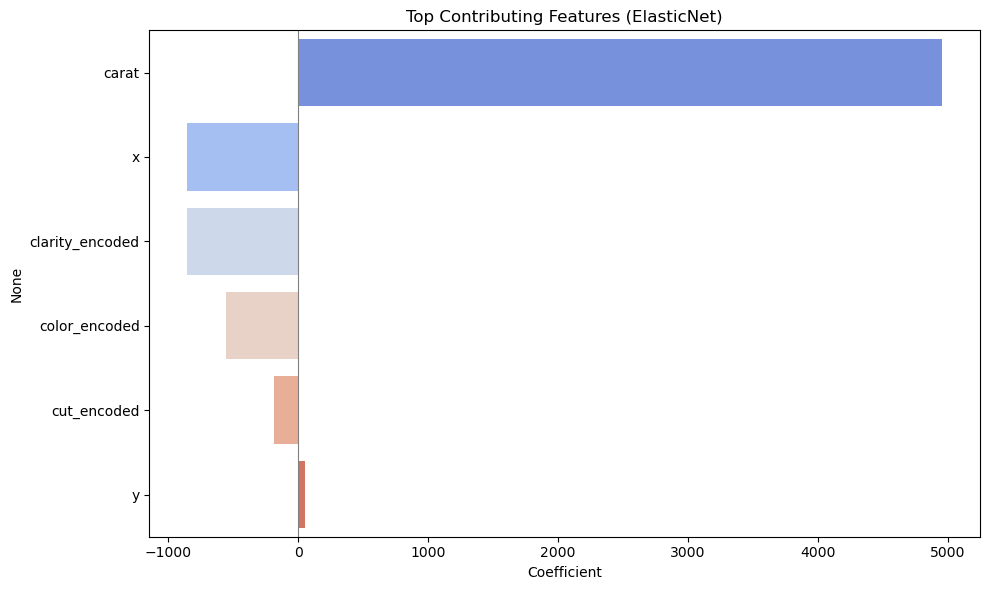

In [43]:
elastic_coefs = pd.Series(elastic_best.coef_, index=OrdDumX.columns)
nonzero_coefs = elastic_coefs[elastic_coefs != 0].sort_values(key=np.abs, ascending=False)

print(nonzero_coefs)

# Optional: Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=nonzero_coefs.values, y=nonzero_coefs.index, palette='coolwarm',hue=nonzero_coefs.index)
plt.title('Top Contributing Features (ElasticNet)')
plt.xlabel('Coefficient')
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

## For a Fixed Budget:

In [44]:
budget = diamonds_df['price'].median()
print(budget)
diamonds_df['price'].value_counts()

2401.0


price
605      132
802      127
625      126
828      125
776      124
        ... 
8816       1
14704      1
14699      1
14698      1
9793       1
Name: count, Length: 11602, dtype: int64

In [45]:
diamonds_df['affordable'] = (diamonds_df['price'] <= budget).astype(int)

deduped_index = OrdDumX.index

#print(len(deduped_index))

In [46]:
y_class = diamonds_df.loc[deduped_index,'affordable']

In [47]:
print(len(deduped_index))
print(f"{len(OrdDumX)}\t{len(y_class)}")
RFClass_Xtrain, RFClass_Xtest, RFClass_ytrain, RFClass_ytest = train_test_split(OrdDumX, y_class, test_size=0.2,random_state=0)

clf = RandomForestClassifier()
clf.fit(RFClass_Xtrain, RFClass_ytrain)

y_pred = clf.predict(RFClass_Xtest)
print(f"{len(RFClass_ytest)}\t{len(y_pred)}")

50968
50968	50968
10194	10194


In [48]:
print(classification_report(RFClass_ytest, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4921
           1       0.92      0.87      0.90      5273

    accuracy                           0.90     10194
   macro avg       0.90      0.90      0.90     10194
weighted avg       0.90      0.90      0.90     10194



In [49]:
# Step 1: Define allowed feature levels (as before)
cut_levels = list(range(int(OrdDumX['cut_encoded'].min()), int(OrdDumX['cut_encoded'].max()) + 1))
color_levels = list(range(int(OrdDumX['color_encoded'].min()), int(OrdDumX['color_encoded'].max()) + 1))
clarity_levels = list(range(int(OrdDumX['clarity_encoded'].min()), int(OrdDumX['clarity_encoded'].max()) + 1))

# Numeric ranges: keep granularity low to reduce size, adjust as needed
carat_vals = np.round(np.linspace(0.2, 3.0, 5), 2)
x_vals = np.round(np.linspace(3.0, 8.0, 3), 2)
y_vals = np.round(np.linspace(3.0, 8.0, 3), 2)

# Step 2: Generate all combinations
combinations = list(product(cut_levels, color_levels, clarity_levels, carat_vals, x_vals, y_vals))
combi_df = pd.DataFrame(combinations, columns=OrdDumX.columns)

# Step 3: Filter to keep combinations within real data bounds
q_min=0.01
q_max=0.99
quant_bounds = OrdDumX.quantile([q_min, q_max])
def is_within_quant_range(row):
    return all(quant_bounds.loc[q_min, col] <= row[col] <= quant_bounds.loc[q_max, col] for col in row.index)

combi_df_filtered = combi_df[combi_df.apply(is_within_quant_range, axis=1)]

# Step 4: Scale and predict
combi_scaled = scaler.transform(combi_df_filtered)

# Wrap back into a DataFrame with correct column names
combi_scaled_df = pd.DataFrame(combi_scaled, columns=OrdDumX.columns)

# Predict using the correctly named DataFrame
combi_df_filtered = combi_df_filtered.copy()  # Ensure it's a copy, not a view
combi_df_filtered.loc[:, 'predicted_price'] = ridgeBest.predict(combi_scaled_df)
# Step 5: Filter by budget
affordable_combinations = combi_df_filtered[combi_df_filtered['predicted_price'] <= budget]
affordable_combinations = affordable_combinations.sort_values(by='predicted_price')


In [50]:
# Show results
print(affordable_combinations.head(10))  # Top 10 affordable combinations

       cut_encoded  color_encoded  clarity_encoded  carat    x    y  \
12571            4              6                8    0.9  8.0  5.5   
12572            4              6                8    0.9  8.0  8.0   
10051            3              6                8    0.9  8.0  5.5   
10052            3              6                8    0.9  8.0  8.0   
12211            4              5                8    0.9  8.0  5.5   
7531             2              6                8    0.9  8.0  5.5   
12212            4              5                8    0.9  8.0  8.0   
7532             2              6                8    0.9  8.0  8.0   
9691             3              5                8    0.9  8.0  5.5   
5011             1              6                8    0.9  8.0  5.5   

       predicted_price  
12571        -5.166529  
12572       115.712198  
10051       161.763066  
10052       282.641792  
12211       323.629270  
7531        328.692660  
12212       444.507996  
7532        449.57

Negative predicted prices typically result from extrapolation, which happens when:

 - Generating synthetic combinations (e.g., via itertools.product()).

 - Combinations include unrealistic or rare combinations not well-represented in the training data.

 - The regression model (especially LinearRegression, Ridge, etc.) blindly extrapolates, producing values outside the observed range — including negatives.